In [1]:
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import numpy as np
import pandas as pd
from matplotlib import colormaps, pyplot as plt
from pandas.api.types import CategoricalDtype
from visutils import *

In [2]:
cps04 = pd.read_csv('./data/acsProcessed20250312.csv')

# create a flag for DC, elsewhere
highInc = cps04.groupby('State')[['Total Income']].mean().sort_values('Total Income', ascending = False).index[0:5]
cps04.loc[cps04['State'] == 'District of Columbia', 'Location'] = 'District of Columbia'
cps04.loc[cps04['State'].isin(highInc[1:]), 'Location'] = 'Other High Income State'
cps04.loc[~cps04['State'].isin(highInc), 'Location'] = 'Elsewhere'

# categorical features for intuitive sorting
a_cats = ['Under 18', '18-64', '65+']
a_type = CategoricalDtype(categories = a_cats, ordered = True)
cps04['Age Group'] = cps04['Age Group'].astype(a_type)

ad_cats = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
ad_type = CategoricalDtype(categories = ad_cats, ordered = True)
cps04['Detailed Age Group'] = cps04['Detailed Age Group'].astype(ad_type)

ms_cats = ['Never married/single', 'Married, spouse present', 'Married, spouse absent', 'Separated', 'Divorced', 'Widowed']
ms_type = CategoricalDtype(categories = ms_cats, ordered = True)
cps04['Marital Status'] = cps04['Marital Status'].astype(ms_type)

msg_cats = ['Single', 'Married', 'Separated/Divorced', 'Widowed']
msg_type = CategoricalDtype(categories = msg_cats, ordered = True)
cps04['Marital Status Group'] = cps04['Marital Status Group'].astype(msg_type)

loc_cats = ['District of Columbia', 'Other High Income State', 'Elsewhere']
loc_type = CategoricalDtype(categories = loc_cats, ordered = True)
cps04['Location'] = cps04['Location'].astype(loc_type)

In [3]:
# focus on career age adults
midage = cps04.loc[cps04['Age Group'] == '18-64'].reset_index(drop = True)

# and career age adults who work full time
midage_ft = midage.loc[midage['Work Status'] == 'Full time'].reset_index(drop = True)

# DC income is substantially higher than other states - why?

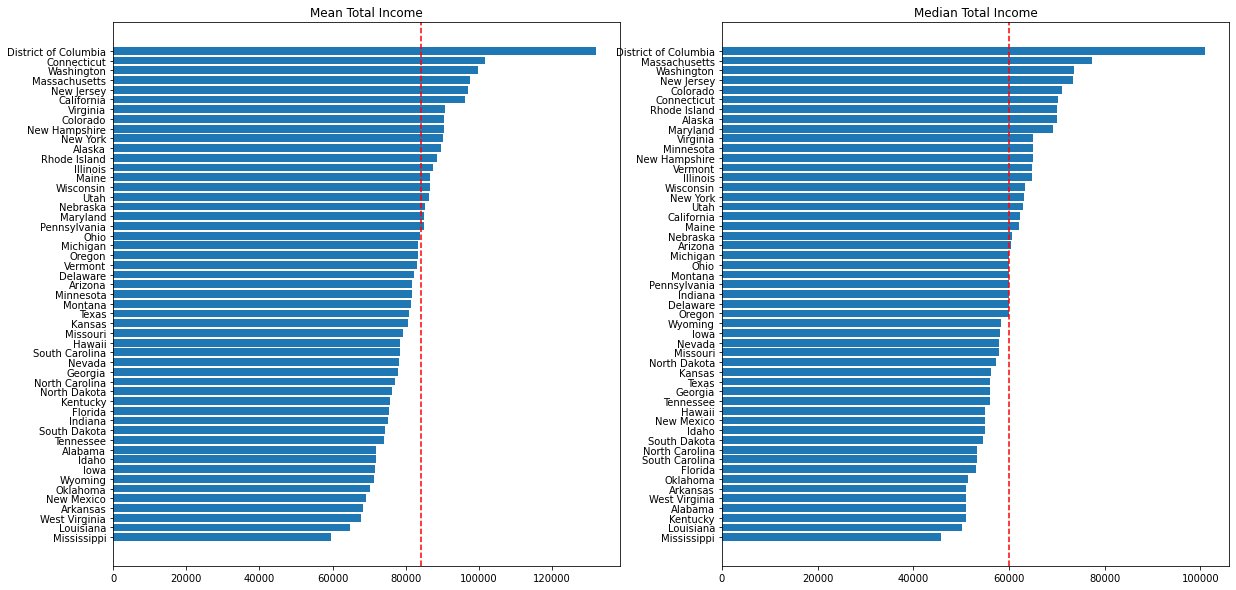

In [4]:
grpd_mn = midage_ft.groupby('State')[['Total Income']].mean().sort_values('Total Income')
grpd_md = midage_ft.groupby('State')[['Total Income']].median().sort_values('Total Income')
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].barh(grpd_mn.index, grpd_mn['Total Income'])
ax[1].barh(grpd_md.index, grpd_md['Total Income'])
ax[0].axvline(midage_ft['Total Income'].mean(), color = 'red', ls = '--')
ax[1].axvline(midage_ft['Total Income'].median(), color = 'red', ls = '--')
ax[0].set_title('Mean Total Income')
ax[1].set_title('Median Total Income')
plt.show()

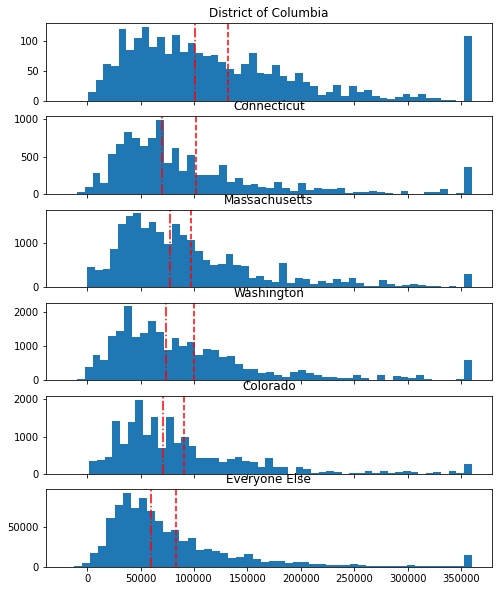

In [5]:
# is it a few outliers or the whole distribution? (significant right skew, not just a few outliers)
fig, axs = plt.subplots(nrows = len(highInc) + 1, ncols = 1, sharex = True, figsize = (8, 10))

for i, st in enumerate(highInc):
    axs[i].hist(midage_ft.loc[midage_ft['State'] == st, 'Capped Income'], bins = 50)
    axs[i].axvline(midage_ft.loc[midage_ft['State'] == st, 'Total Income'].mean(), color = 'red', linestyle = '--')
    axs[i].axvline(midage_ft.loc[midage_ft['State'] == st, 'Total Income'].median(), color = 'red', linestyle = '-.')
    axs[i].set_title(st)

axs[len(highInc)].hist(midage_ft.loc[~midage_ft['State'].isin(highInc), 'Capped Income'], bins = 50)
axs[len(highInc)].axvline(midage_ft.loc[~midage_ft['State'].isin(highInc), 'Total Income'].mean(), color = 'red', linestyle = '--')
axs[len(highInc)].axvline(midage_ft.loc[~midage_ft['State'].isin(highInc), 'Total Income'].median(), color = 'red', linestyle = '-.')
axs[len(highInc)].set_title('Everyone Else')

plt.show()

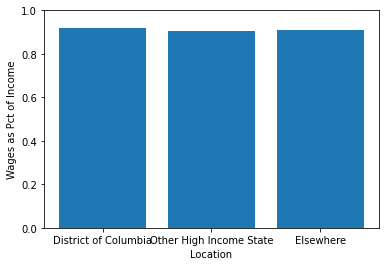

In [6]:
# does the extra income come from wages? (yes)
singleBar(midage_ft, 'Location', 'Wages as Pct of Income', yl = (0, 1))

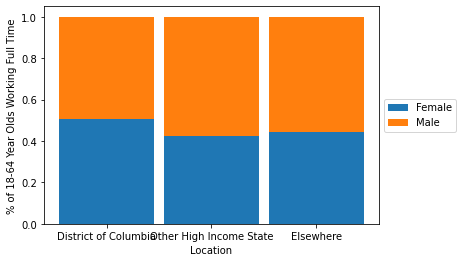

In [7]:
# do DC residents skew male? (no, female)
stackedBar(midage_ft, 'Location', 'Sex', 'Total Income', scale = True, ylab = '% of 18-64 Year Olds Working Full Time')

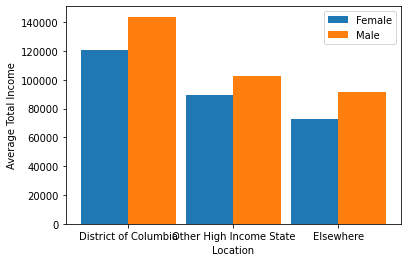

In [8]:
# is the wage gap reversed there? (no)
groupedBar(midage_ft, 'Location', 'Sex', 'Total Income', function = 'mean'
           , ylab = 'Average Total Income')

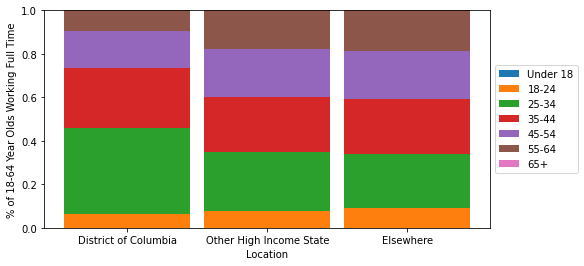

In [9]:
stackedBar(midage_ft, 'Location', 'Detailed Age Group', 'Total Income'
           , scale = True, ylab = '% of 18-64 Year Olds Working Full Time'
           , figsize = (8, 4)
          )

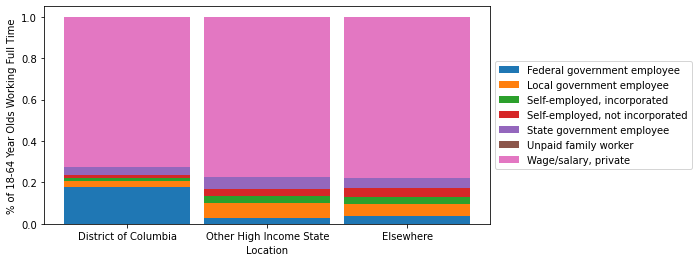

In [10]:
stackedBar(midage_ft#.loc[midage_ft['Worker Class'] != 'Unpaid family worker']
           , 'Location', 'Worker Class', 'Total Income', scale = True
           , ylab = '% of 18-64 Year Olds Working Full Time'
           , figsize = (8, 4)
          )

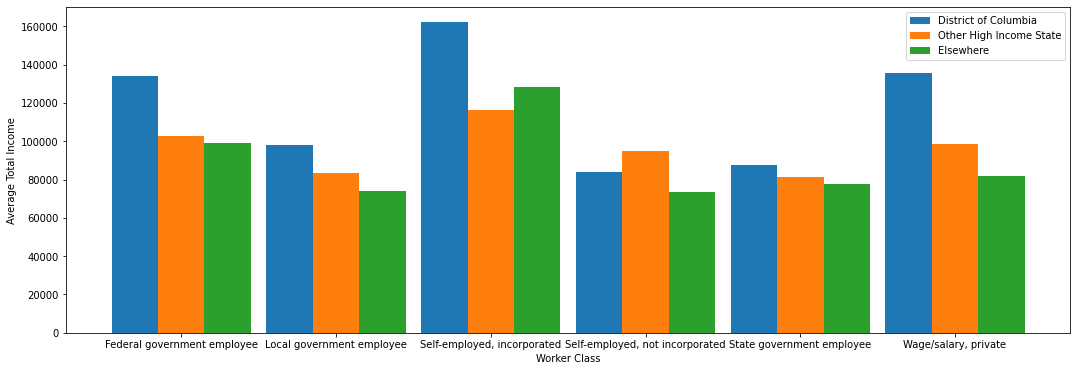

In [11]:
# does income vary by sector differently there? (pay disparity most extreme for fed, self employed (inc), and private)
midage_ft_nu = midage_ft.loc[midage_ft['Worker Class'] != 'Unpaid family worker'].reset_index(drop = True)

groupedBar(midage_ft_nu, 'Worker Class', 'Location', 'Total Income', function = 'mean'
           , ylab = 'Average Total Income', figsize = (18, 6))

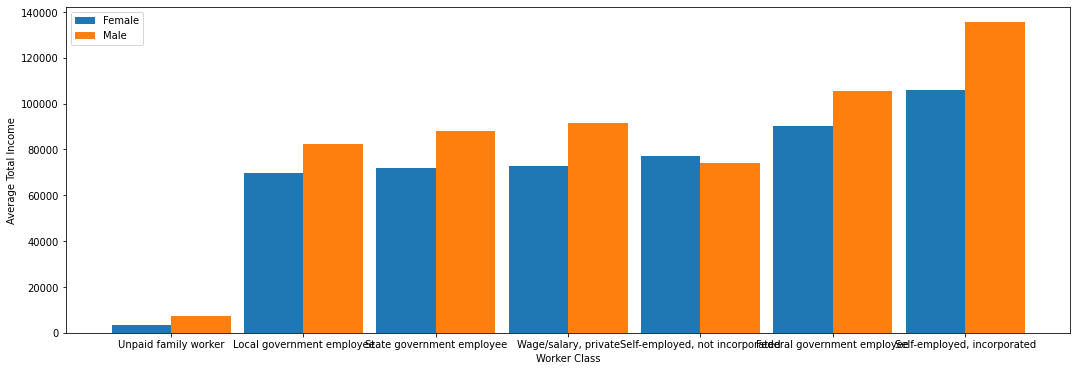

In [12]:
# does this vary by sex?
groupedBar(midage_ft, 'Worker Class', 'Sex', 'Total Income'
           , ylab = 'Average Total Income', sortvalues = True, figsize = (18, 6)
          )

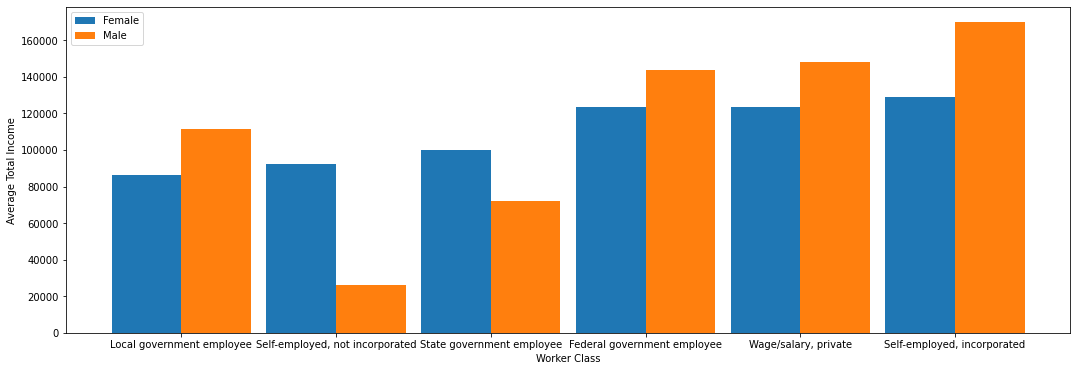

In [13]:
# maybe in DC in particular?
groupedBar(midage_ft.loc[midage_ft['State'] == 'District of Columbia'], 'Worker Class', 'Sex', 'Total Income'
           , ylab = 'Average Total Income', sortvalues = True, figsize = (18, 6)
          )

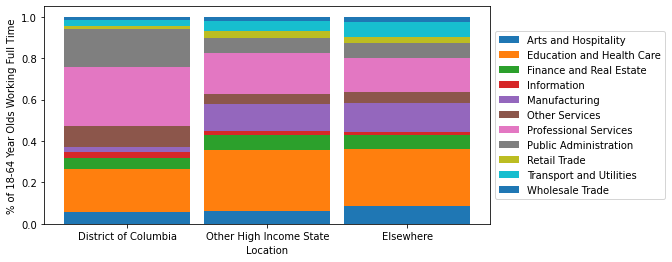

In [14]:
stackedBar(midage_ft
           , 'Location', 'Industry Area', 'Total Income'
           , scale = True, ylab = '% of 18-64 Year Olds Working Full Time'
           , figsize = (8, 4)
          )

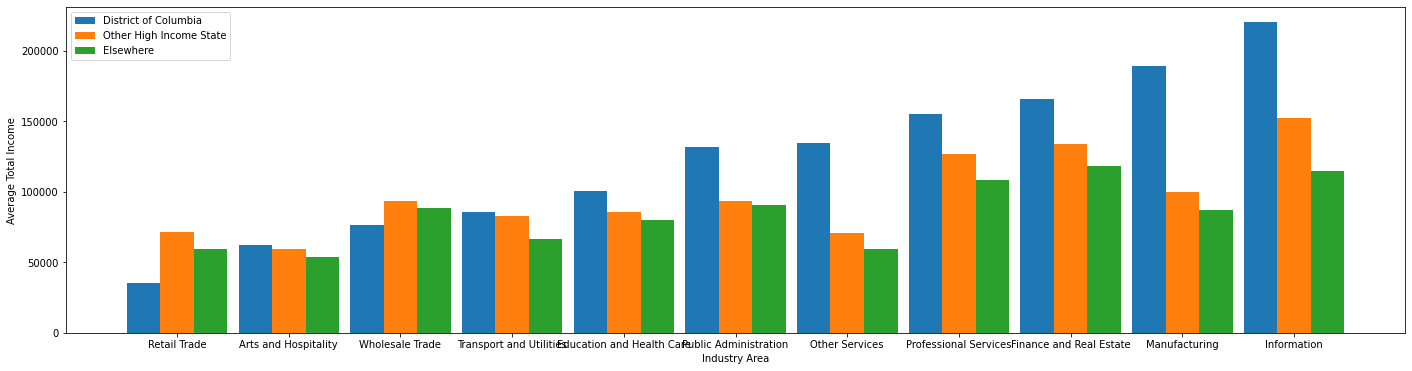

In [15]:
groupedBar(midage_ft, 'Industry Area', 'Location', 'Total Income', function = 'mean'
           , sortvalues = True
           , ylab = 'Average Total Income', figsize = (24, 6))

In [16]:
midage_ft.loc[midage_ft['Industry Area'] == 'Information'].groupby('Industry Description')[['Total Income']].count().sort_values('Total Income', ascending = False)

,Total Income
Industry Description,
Wired telecommunications carriers,3302
"Telecommunications, except wired telecommunications carriers",2980
Motion pictures and video industries,2550
Software publishers,2478
"Computing infrastructure providers, data processing, web hosting, and related services",1293
Libraries and archives,798
Sound recording industries,373
